## Angela Shane



### Data Engineering

* Uses Pandas to read in the measurement and station CSV files as DataFrames.
* Inspects the data for NaNs and missing values and replaces them with 0 values.
* Saves the cleaned CSV files with the prefix clean_.


### Database Engineering

* Uses Pandas to read the cleaned measurements and stations CSV data.
* Uses the SQLAlchemy engine and connection string to create a database called hawaii.sqlite.
* Uses the declarative_base and creates ORM classes for each table.
* Creates the tables in the database using create_all.


### Climate Analysis

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect, func

In [2]:
# Database Setup
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [4]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurements', 'stations']

In [6]:
# Assign the measurements class to a variable called `Measurements`
# Assign the stations class to a variable called `Stations`
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [7]:
# Create a session
session = Session(engine)

In [8]:
# Get a list of column names and types
inspector = inspect(engine)
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs INTEGER


In [9]:
df = pd.DataFrame(session.query(Measurements.station, Measurements.date, Measurements.prcp, Measurements.tobs).all())
df.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65
1,USC00519397,2010-01-02,0.00,63
2,USC00519397,2010-01-03,0.00,74
3,USC00519397,2010-01-04,0.00,76
4,USC00519397,2010-01-06,NaN,73


## Precipitation Analysis
* Design a query to retrieve the last 12 months of precipitation data.
* Select only the date and prcp values.
* Load the query results into a Pandas DataFrame and set the index to the date column.
* Plot the results using the DataFrame plot method.

In [10]:
prcp = df[(df.date >= '2011-02-01') & (df.date <= '2012-01-31')].groupby(['date']).sum()
prcp.drop('tobs',inplace=True, axis=1)
prcp.sort_index()
prcp.head()

,prcp
date,
2011-02-01,0.25
2011-02-02,0.01
2011-02-03,0.00
2011-02-04,0.02
2011-02-05,0.00


In [11]:
x_axis = np.arange(len(prcp.prcp))
x_lbls = [value for idx, value in enumerate(prcp.index) if idx % 28 == 0]

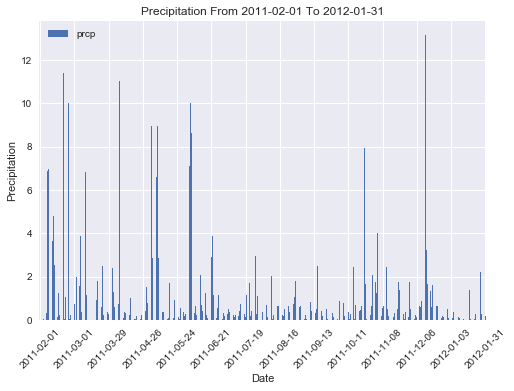

In [12]:
prcp.plot.bar()
tick_locations = [value + 0.1 for idx, value in enumerate(x_axis) if idx % 28 == 0]
plt.xticks(tick_locations, x_lbls, rotation=45)
plt.title("Precipitation From " + prcp.index[0] + " To " + prcp.index[-1])
plt.xlabel("Date")
plt.ylabel("Precipitation")
sns.set()
plt.savefig('precipitation.png')
plt.show()

## Station Analysis

* Design a query to calculate the total number of stations.
* Design a query to find the most active stations.
* List the stations and observation counts in descending order
* Which station has the highest number of observations?
* Design a query to retrieve the last 12 months of temperature observation data (tobs).
* Filter by the station with the highest number of observations.
* Plot the results as a histogram with bins=12.

In [13]:
stations = df.station.unique()
num_stations = len(stations)

In [14]:
# stations and observation counts in descending order
df.groupby('station')['date'].count().sort_values(ascending=False)

station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: date, dtype: int64

### Observation: Station USC00519281 has the highest number of observations with 2772 observations

In [15]:
max_station = 'USC00519281'
station = df[(df.station == max_station) & (df.date >= '2011-02-01') & (df.date <= '2012-01-31') ].groupby(['date']).sum()
station.sort_index()
station.head()

,prcp,tobs
date,,
2011-02-01,0.0,62
2011-02-02,0.0,67
2011-02-03,0.0,68
2011-02-04,0.0,62
2011-02-05,0.0,65


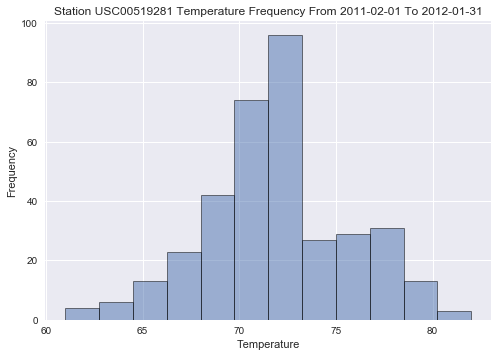

In [16]:
plt.hist(station.tobs, bins=12, alpha=0.5, edgecolor='black', linewidth='1')
plt.title("Station " + max_station + " Temperature Frequency From " + station.index[0] + " To " + station.index[-1])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
sns.set()
plt.savefig('temperature.png')
plt.show()

## Temperature Analysis
* Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
* Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")
* Plot the min, avg, and max temperature from your previous query as a bar chart.
* Use the average temperature as the bar height.
* Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [17]:
def calc_temps(start_date, end_date):
    temps = df[(df.date >= start_date) & (df.date <= end_date)]
    min_temp = temps.tobs.min()
    max_temp = temps.tobs.max()
    mean_temp = temps.tobs.mean()
    return (min_temp, max_temp, mean_temp)

In [18]:
tmin, tmax, tmean = calc_temps('2011-02-01', '2012-01-31')
tmin, tmax, tmean

(56, 86, 72.80798827409308)

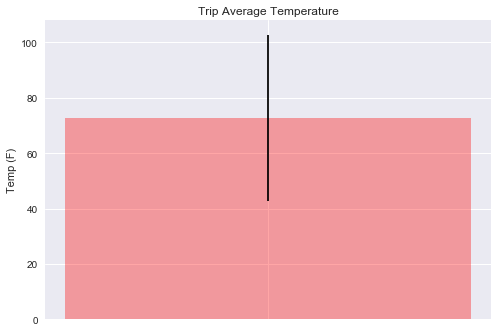

In [19]:
x = ['']
energy = [tmean]
variance = [tmax-tmin]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='red', alpha=.35, yerr=variance)
plt.ylabel("Temp (F)")
plt.title("Trip Average Temperature")

plt.xticks(x_pos, x)
sns.set()
plt.show()
plt.savefig('average_trip_temperature.png')